# Data Splitting for Category-based Sales Forecasting

This notebook splits the preprocessed sales data into separate files based on product category (category_detailed). These separate files will be used for category-based model training.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from tqdm.notebook import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

## 1. Load Preprocessed Sales Data

First, we load the preprocessed sales data that contains all our features.

In [2]:
# Define file paths
SALES_FILE = '../data/processed/sales_processed.csv'
OUTPUT_DIR = '../data/splits/'

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load the preprocessed sales data
print(f"Loading preprocessed sales data from {SALES_FILE}...")
df_sales = pd.read_csv(SALES_FILE)

print(f"Loaded sales data with {len(df_sales):,} rows and {len(df_sales.columns)} columns")

# Display some basic information
print("\nSales data info:")
print(df_sales.info())

Loading preprocessed sales data from ../data/processed/sales_processed.csv...
Loaded sales data with 39,299,982 rows and 64 columns

Sales data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39299982 entries, 0 to 39299981
Data columns (total 64 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   matrix_type                object 
 1   type_bonus_id              object 
 2   qnt                        float64
 3   qnt_loss                   float64
 4   discount                   float64
 5   action_mediana_price       float64
 6   reg_mediana_price          float64
 7   bu_exists                  int64  
 8   brand_id                   int64  
 9   shelf                      float64
 10  country_id                 object 
 11  unit                       object 
 12  netto                      float64
 13  brutto                     float64
 14  type_for_customer          int64  
 15  regular_pnz                float64
 16  promo_pnz 

## 2. Define Groups for Splitting

We'll split the data based on the `category_detailed` column, which represents the detailed product category.

Creating groups based on product category_detailed...

Found 11 unique category groups
Found 11 category groups with at least 1000 samples each

Top 10 category groups by sample count:


group
4202    7543435
3801    6181336
2314    5270299
3501    5091927
3106    4887522
2802    3548302
3705    2033387
1705    1526275
2506    1498937
2404    1380448
Name: count, dtype: int64

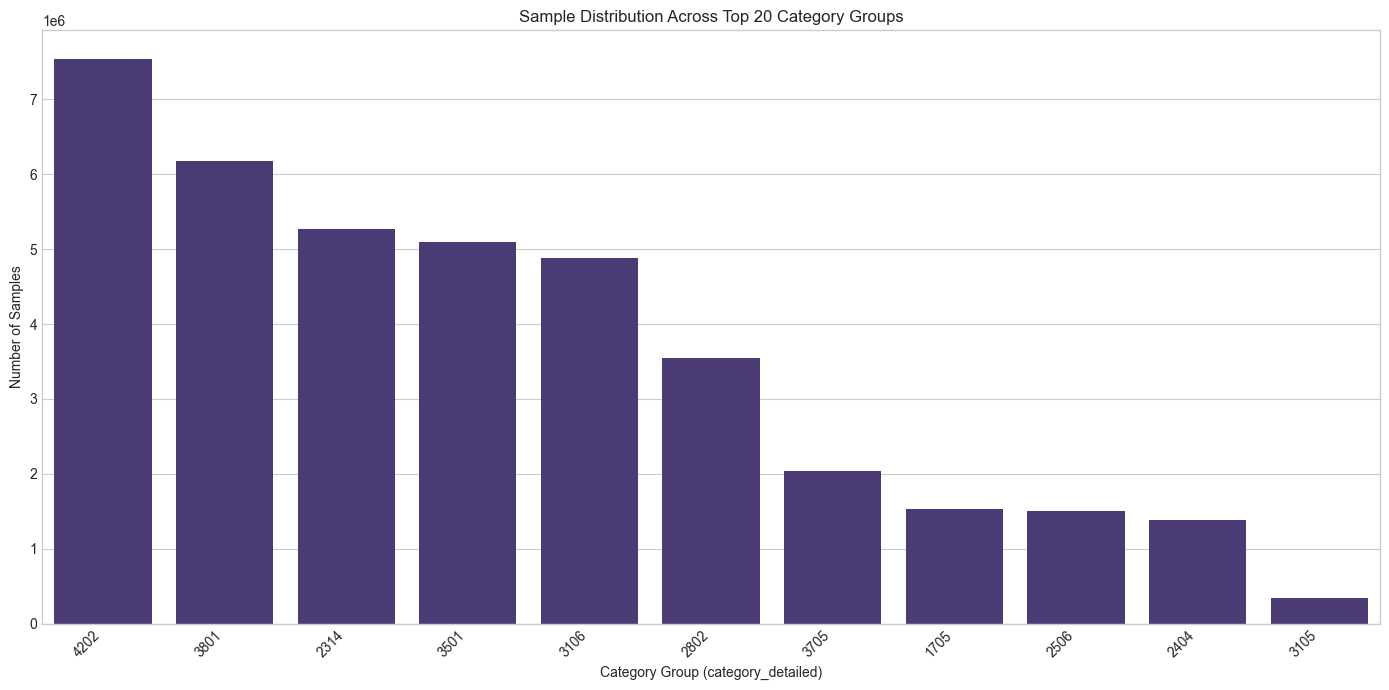

Selected category groups cover 100.00% of the total data (39,299,982 out of 39,299,982 samples)


In [3]:
# Check if the category_detailed column is present
if 'category_detailed' not in df_sales.columns:
    print(f"Warning: Missing 'category_detailed' column")
    print("Will use category_major instead as a fallback for grouping")
    # Fallback to category_major if category_detailed isn't available
    df_sales['group'] = df_sales['category_major'].astype(str)
else:
    # Create a group column using category_detailed
    print("Creating groups based on product category_detailed...")
    df_sales['group'] = df_sales['category_detailed'].astype(str)

# Count records per group
group_counts = df_sales['group'].value_counts()
print(f"\nFound {len(group_counts)} unique category groups")

# Filter groups with sufficient data (at least 1000 samples)
min_samples = 1000
large_groups = group_counts[group_counts >= min_samples]
print(f"Found {len(large_groups)} category groups with at least {min_samples} samples each")

# Display the top 10 groups by count
print("\nTop 10 category groups by sample count:")
display(large_groups.head(10))
top_groups = large_groups.index
    
# Visual distribution of samples across groups
plt.figure(figsize=(14, 7))
sns.barplot(x=large_groups.head(20).index, y=large_groups.head(20).values)
plt.title('Sample Distribution Across Top 20 Category Groups')
plt.xlabel('Category Group (category_detailed)')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Check the total number of samples in selected groups vs all data
samples_in_selected = sum(large_groups)
total_samples = len(df_sales)
coverage = samples_in_selected / total_samples * 100
print(f"Selected category groups cover {coverage:.2f}% of the total data ({samples_in_selected:,} out of {total_samples:,} samples)")

## 3. Split and Save Data by Category Group

Now we'll create separate CSV files for each category group.

In [4]:
# Initialize a summary DataFrame to track the splits
split_summary = []

print(f"Splitting data into {len(top_groups)} separate files...")

# Process each group
for i, group in enumerate(tqdm(top_groups)):
    # Filter data for this group
    group_data = df_sales[df_sales['group'] == group].copy()
    
    # Create a clean filename by replacing invalid characters
    clean_name = str(group).replace('/', '_').replace('\\', '_').replace(' ', '_')
    filename = f"sales_category_{i+1:02d}_{clean_name}.csv"
    filepath = os.path.join(OUTPUT_DIR, filename)
    
    # Add to summary
    split_summary.append({
        'File': filename,
        'Group': clean_name,
        'Samples': len(group_data)
    })
    
    # Save the data
    group_data.to_csv(filepath, index=False)

# Save summary
# summary_df = pd.DataFrame(split_summary)
# summary_df.to_csv(os.path.join(OUTPUT_DIR, "split_summary.csv"), index=False)
# print(f"\nSummary of splits:")
# display(summary_df)

Splitting data into 11 separate files...


  0%|          | 0/11 [00:00<?, ?it/s]

## 4. Conclusion

We've successfully split the sales data into separate files based on product categories (using the category_detailed column). These files are now ready to be used in the `05_experiments.ipynb` notebook, where we'll train and evaluate models separately for each category group.